Kalibrierung einer Kamera und Messung von Längen von Objekten
und Messung von Distanzen, die ein Objekt zurückgelegt hat

Zuerst muss herausgefunden werden, welches Kamera benutzt werden soll. In diesem Beispiel benutzen wir "video3"

In [1]:
import subprocess

#Bash script that uses v4l2-ctl to find the camera id-thingy. you probably don't have v4l2 installed.
# subprocess.run(args="",executable="./webcam_setup.sh")
subprocess.run("ls /dev | grep video",shell=True)


video0
video1


CompletedProcess(args='ls /dev | grep video', returncode=0)

In [2]:
import matplotlib.pyplot as plt
import cv2
import os
from skimage import color, feature, io, util, measure, filters
from scipy import ndimage as ndi
#TODO shell befehl in python aufrufen und parsen?
# abbruch
# distanzmessung Wenn stift sich bewegt

FILENAME2 = "distance_test.png"
FILENAME = "calibresult.png"
IMG_TO_MEASURE_PATH = "./data/Objekt101.png"
SPACE_KEY_PRESS = 32
VIDEO_CAM=3

Kalibrierung der Kamera
Aufnehmen von mindestens 10, besser 30+ Bildern
3d 2d



mindestens 15 Zeilen

In [3]:
import os
import numpy as np
import cv2 as cv
import glob
# termination criteria
def calibrate():
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((9*7,3), np.float32)
    objp[:,:2] = np.mgrid[0:7,0:9].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
    directory="./data/"
    images=[]
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f):
            print(f)
            images.append(f)
    found_imgs, imgs_counter = 0, 0

    for fname in images:
        img = cv.imread(fname)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, (7,9), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray,corners, (7,9), (-1,-1), criteria)
            imgpoints.append(corners2)
            found_imgs += 1
            # Draw and display the corners
            cv.drawChessboardCorners(img, (7,9), corners2, ret)
            # cv.imshow('img', img)
            # cv.waitKey(500)

    cv.destroyAllWindows()

    print("Checker board detected {}/{}".format(found_imgs, imgs_counter))
    objpoints, imgpoints = np.array(objpoints, dtype=np.float32), np.array(imgpoints, dtype=np.float32)
    ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    print('Camera Matrix', mtx)
    print('Distortion Mat', dist)

    img = cv.imread('./data/checkerboard_101.png')
    h,  w = img.shape[:2]
    newcameramtx, roi = cv.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

    # undistort
    dst = cv.undistort(img, mtx, dist, None, newcameramtx)
    # crop the image
    x, y, w, h = roi
    dst = dst[y:y+h, x:x+w]
    cv.imwrite('calibresult.png', dst)

    mean_error = 0
    for i in range(len(objpoints)):
        imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
        error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
        mean_error += error
    print( "total error: {}".format(mean_error/len(objpoints)) )
calibrate()


./data/checkerboard_132.png
./data/checkerboard_116.png
./data/checkerboard_113.png
./data/checkerboard_131.png
./data/checkerboard_108.png
./data/checkerboard_114.png
./data/checkerboard_104.png
./data/checkerboard_115.png
./data/checkerboard_138.png
./data/checkerboard_140.png
./data/checkerboard_117.png
./data/checkerboard_101.png
./data/checkerboard_144.png
./data/checkerboard_127.png
./data/checkerboard_119.png
./data/checkerboard_139.png
./data/checkerboard_134.png
./data/checkerboard_126.png
./data/checkerboard_124.png
./data/checkerboard_103.png
./data/checkerboard_133.png
./data/checkerboard_130.png
./data/checkerboard_106.png
./data/checkerboard_118.png
./data/checkerboard_111.png
./data/checkerboard_142.png
./data/checkerboard_105.png
./data/checkerboard_135.png
./data/checkerboard_123.png
./data/checkerboard_136.png
./data/checkerboard_141.png
./data/Objekt101.png
./data/Objekt.png
./data/checkerboard_109.png
./data/checkerboard_137.png
./data/checkerboard_122.png
./data/ch

Edge Detection with Canny

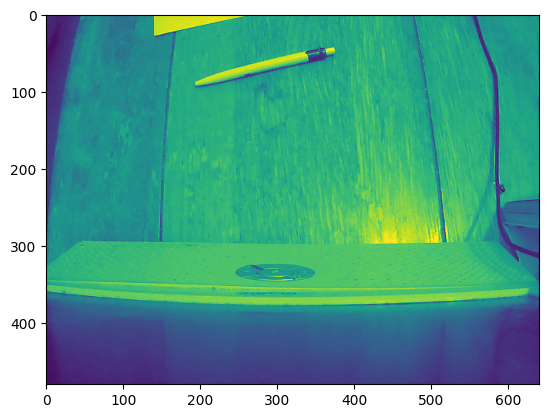

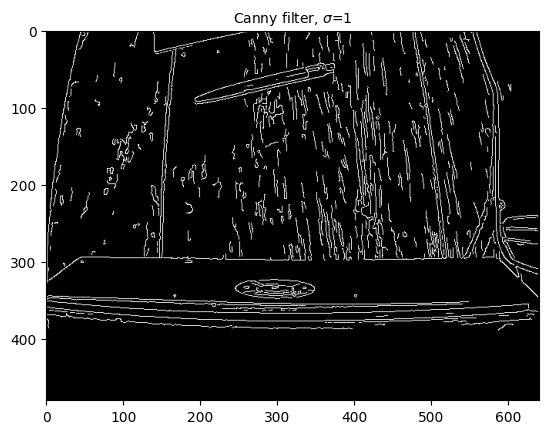

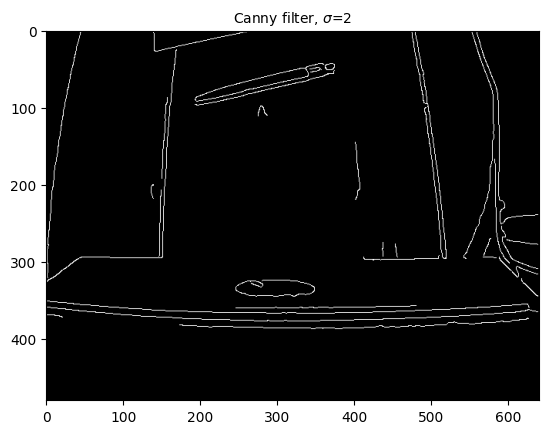

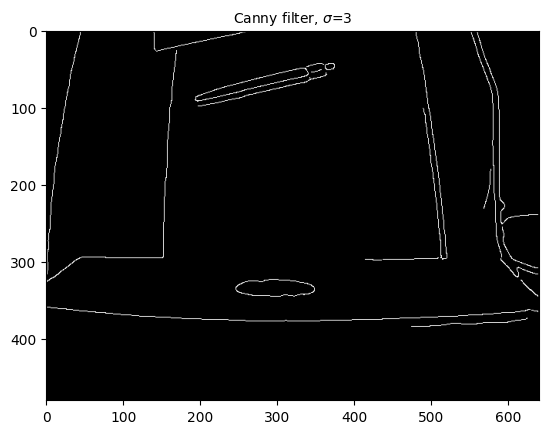

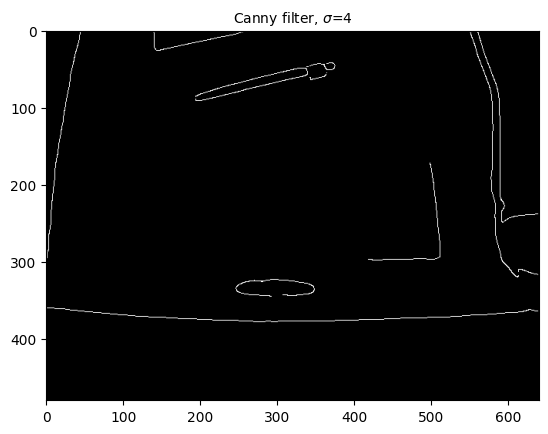

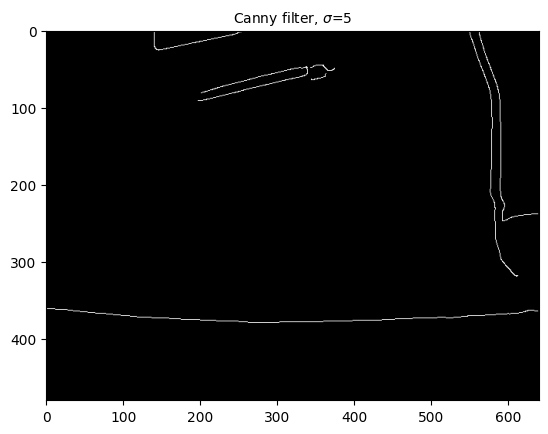

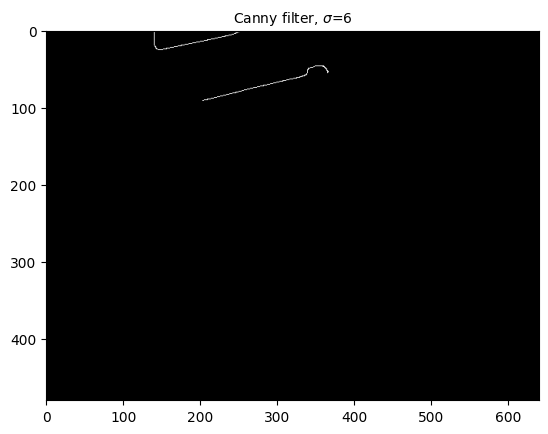

In [4]:
image=io.imread(IMG_TO_MEASURE_PATH)
plt.imshow(image)
plt.show()
# Compute the Canny filter for some values of sigma
edges_list=[]
sigmas=[1,2,3,4,5,6]
for sigma in sigmas:
    edges_list.append(feature.canny(image,sigma=sigma))


# display results
plt.imshow(image, cmap='gray')
plt.title('noisy image', fontsize=20)

for i in range(0,len(sigmas)):
    plt.imshow(edges_list[i], cmap='gray')
    plt.title(r'Canny filter, $\sigma$'+"="+str(sigmas[i]), fontsize=10)
    plt.show()

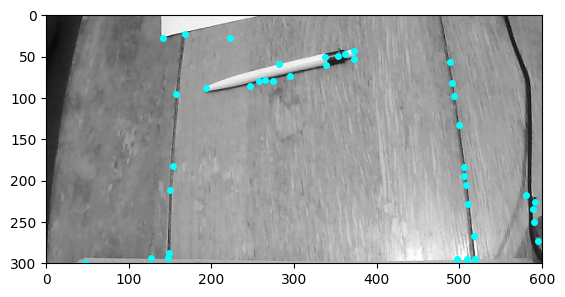

In [9]:
import skimage
from skimage import io, color, morphology, transform, data, draw, feature
from skimage.feature import *
import matplotlib.pyplot as plt


image = io.imread(IMG_TO_MEASURE_PATH)
something: np.ndarray = corner_harris(image, k=0.01, eps=0, sigma=1)
# plt.title("something")
# plt.imshow(something)
# plt.show()
coords = corner_peaks(corner_harris(image), min_distance=3, threshold_rel=0.01)
coords_subpix = corner_subpix(image, coords, window_size=10)

fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o', linestyle='None', markersize=4)
# plt.show()
# ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=15)
ax.axis((0, 600, 300, 0))
plt.show()

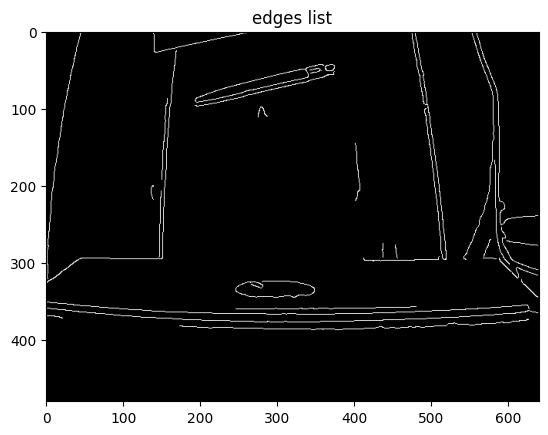

shape= (480, 640)
(307200,)
[[0.001 0.001 0.001]
 [0.001 0.001 0.001]
 [0.001 0.001 0.001]]
(480, 640)
640
(13, 11)
5


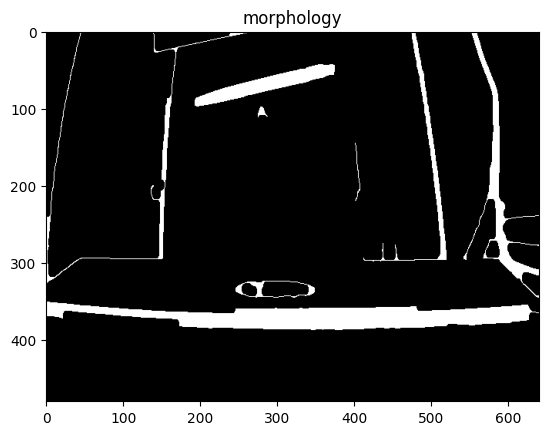

8


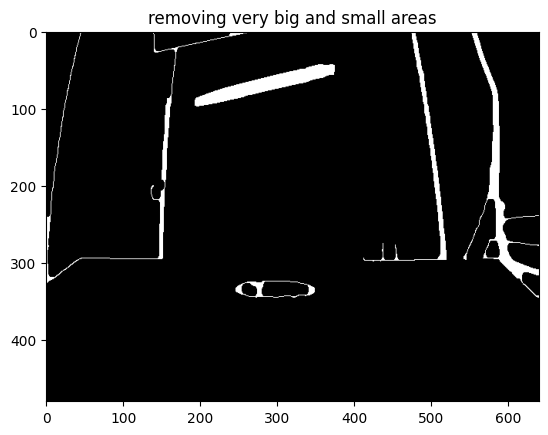

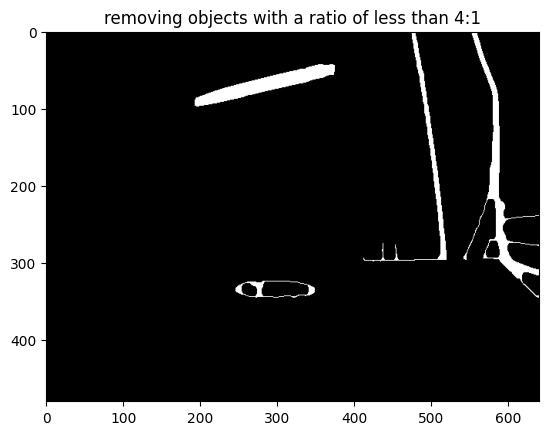

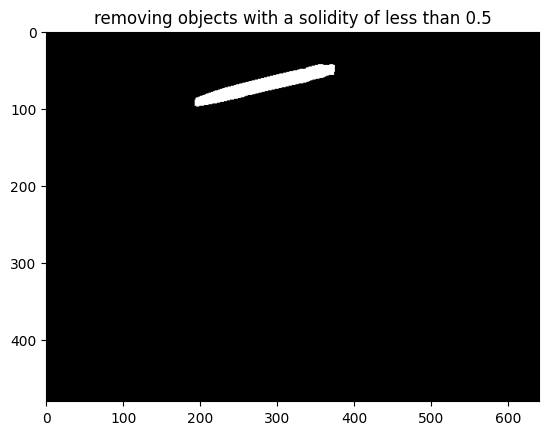

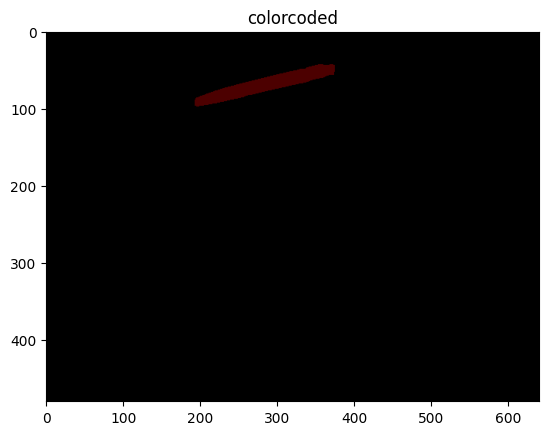

pixel_per_cm= 10.85634844514219
Länge= 18.99762588879077
centroid_location= (68.86428798980567, 285.3985345651481)


In [13]:
from skimage.measure._regionprops import RegionProperties
images_with_movement=[]
for image in images_with_movement:
    #TODO make 2 images and redo calibration from the zenith
    pass

img: np.ndarray = edges_list[1]
plt.imshow(img)
plt.title("edges list")
plt.show()

shape = img.shape
print("shape=", shape)
img = img.reshape(shape[0]*shape[1])
plt.set_cmap("gray")
print(img.shape)
img = [1 if x != False else 0.001 for x in img]
img = np.array(img)
img = img.reshape(shape)
print(img[:3, :3])
# img = 1-img
print(img.shape)
label = measure.label(img)
print(len(label[0]))
img_colorcoded = color.label2rgb(label, img)
# plt.imshow(img_colorcoded)
# plt.colorbar()
# plt.show()

# closing
ellipse_radius=5
img=edges_list[1]
fp_ellipse = morphology.ellipse(ellipse_radius, ellipse_radius+1, dtype="bool")
print(fp_ellipse.shape)
for i in range(6):
    img = morphology.closing(img, fp_ellipse)
print("closing operation repeated times:",i)
# img = morphology.dilation(img)
plt.imshow(img)
plt.title("morphology")
plt.show()

# a region analysis
label = measure.label(img)
regions = measure.regionprops(label)
print(len(regions))
img = np.zeros(img.shape)
x = 0
for region in regions:
    if region.area < 9000 and region.area > 200:
        x += 1
        coords = region.coords
        for y, z in coords:
            img[y, z] = 1
plt.imshow(img)
plt.title("removing very big and small areas")
plt.show()

label = measure.label(img)
regions = measure.regionprops(label)
img = np.zeros(img.shape)
for region in regions:
    region:measure._regionprops.RegionProperties=region
    if region.axis_major_length/region.axis_minor_length >4:
        x += 1
        coords = region.coords
        for y, z in coords:
            img[y, z] = 1
plt.imshow(img)
plt.title("removing objects with a ratio of less than 4:1")
plt.show()

label = measure.label(img)
regions = measure.regionprops(label)
img = np.zeros(img.shape)
for region in regions:
    region:RegionProperties=region
    if region.solidity >0.4:
        x += 1
        coords = region.coords
        for y, z in coords:
            img[y, z] = 1
plt.imshow(img)
plt.title("removing objects with a solidity of less than 0.5")
plt.show()

label = measure.label(img)
regions = measure.regionprops(label)
img = np.zeros(img.shape)
# for region in regions:
#     for prop in region:
#         print(prop, region[prop])
#         pass
img_colorcoded = color.label2rgb(label, img)
plt.imshow(img_colorcoded)
plt.title("colorcoded")
plt.show()
with open("pixel_per_cm.txt") as file:
    pixel_per_cm=float(file.read())
print("pixel_per_cm=",pixel_per_cm)

centroids=[]
for region in regions:
    print("Länge=",region.major_axis_length/pixel_per_cm)
    print("centroid_location=",region.centroid)
    centroids.append(region.centroid)